In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings

In [2]:
# Load dataset
df = pd.read_csv('../../data/player_game_statistics.csv')
display(df.columns)

Index(['stat_id', 'player_id', 'player_name', 'age', 'gender', 'country',
       'game_id', 'game_name', 'total_games_played', 'total_wins',
       'total_losses', 'total_moves', 'total_time_played_minutes', 'win_ratio',
       'rating', 'last_played'],
      dtype='object')

In [3]:
# Inspect the target column (game engagement duration)
print(df.head())

                                stat_id                             player_id  \
0  3407ea25-ba61-11ef-9d4e-00155d326b4e  d16771fa-ba60-11ef-9d4e-00155d326b4e   
1  3409a88e-ba61-11ef-9d4e-00155d326b4e  d133c41a-ba60-11ef-9d4e-00155d326b4e   
2  3409bca3-ba61-11ef-9d4e-00155d326b4e  d15034ff-ba60-11ef-9d4e-00155d326b4e   
3  340a17ca-ba61-11ef-9d4e-00155d326b4e  d15ee3cd-ba60-11ef-9d4e-00155d326b4e   
4  340a5066-ba61-11ef-9d4e-00155d326b4e  d1224a65-ba60-11ef-9d4e-00155d326b4e   

       player_name  age      gender country  \
0   David Gonzales   34      Female  Canada   
1     Joseph Davis   18      Female   Japan   
2  Isabella Martin   51  Non-Binary   Spain   
3   Michael Thomas   33  Non-Binary      UK   
4    Evelyn Thomas   18  Non-Binary  Brazil   

                                game_id   game_name  total_games_played  \
0  d0ac190e-ba60-11ef-9d4e-00155d326b4e  battleship                 170   
1  d0ac190e-ba60-11ef-9d4e-00155d326b4e  battleship                 148   
2  d0

In [4]:
# Convert last_played to datetime and create initial derived features
df['last_played'] = pd.to_datetime(df['last_played'])
current_time = pd.to_datetime('now')
df['days_since_last_play'] = (current_time - df['last_played']).dt.total_seconds() / (60 * 60 * 24)
df['avg_session_duration'] = df['total_time_played_minutes'] / df['total_games_played']
df['avg_moves_per_game'] = df['total_moves'] / df['total_games_played']
df['games_per_day'] = df['total_games_played'] / (df['days_since_last_play'] + 1)
df['time_per_day'] = df['total_time_played_minutes'] / (df['days_since_last_play'] + 1)

In [5]:
# Analyze game-specific metrics
print("Game-specific engagement analysis:")
game_metrics = df.groupby('game_name').agg({
    'total_time_played_minutes': ['mean', 'std'],
    'avg_session_duration': 'mean',
    'total_games_played': 'mean',
    'win_ratio': 'mean'
}).round(2)

print("\nGame-specific metrics:")
print(game_metrics)


Game-specific engagement analysis:

Game-specific metrics:
               total_time_played_minutes          avg_session_duration  \
                                    mean      std                 mean   
game_name                                                                
battleship                       4703.54  1718.94                34.31   
chess                            1130.01   596.83                34.96   
connect four                      851.08   509.50                34.66   
dots and boxes                    644.61   373.10                34.12   
tic tac toe                       927.69   371.84                34.38   

               total_games_played win_ratio  
                             mean      mean  
game_name                                    
battleship                 137.08     50.09  
chess                       32.31     45.55  
connect four                24.58     46.43  
dots and boxes              18.87     51.05  
tic tac toe               

In [6]:
# Create time-based features
current_time = pd.to_datetime('now')
df['days_since_last_play'] = (current_time - df['last_played']).dt.total_seconds() / (60 * 60 * 24)
df['avg_session_duration'] = df['total_time_played_minutes'] / df['total_games_played']
df['avg_moves_per_game'] = df['total_moves'] / df['total_games_played']
df['games_per_day'] = df['total_games_played'] / (df['days_since_last_play'] + 1)
df['time_per_day'] = df['total_time_played_minutes'] / (df['days_since_last_play'] + 1)

In [7]:
# Encode game names
label_encoder = LabelEncoder()
df['game_encoded'] = label_encoder.fit_transform(df['game_name'])

In [8]:
# Create target variables
y_total_time = df['total_time_played_minutes']
y_avg_session = df['avg_session_duration']

In [9]:
# Select features for prediction
features = [
    'age',
    'total_games_played',
    'win_ratio',
    'rating',
    'avg_moves_per_game',
    'games_per_day',
    'days_since_last_play',
    'game_encoded'  # Added game as a feature
]

X = df[features]


In [10]:
# Split data for total time prediction
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(
    X, y_total_time, test_size=0.2, random_state=42
)

In [11]:
# Split data for session duration prediction
X_train_session, X_test_session, y_train_session, y_test_session = train_test_split(
    X, y_avg_session, test_size=0.2, random_state=42
)

In [12]:
# Scale features
scaler = StandardScaler()
X_train_time_scaled = scaler.fit_transform(X_train_time)
X_test_time_scaled = scaler.transform(X_test_time)

X_train_session_scaled = scaler.fit_transform(X_train_session)
X_test_session_scaled = scaler.transform(X_test_session)

In [13]:
# Define models
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

In [14]:
# Train models for total time prediction
rf_time = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=5,
    scoring='r2'
)

xgb_time = GridSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    xgb_params,
    cv=5,
    scoring='r2'
)

rf_time.fit(X_train_time_scaled, y_train_time)
xgb_time.fit(X_train_time_scaled, y_train_time)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200]},
             scoring='r2')

In [15]:
# Train models for session duration prediction
rf_session = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=5,
    scoring='r2'
)

xgb_session = GridSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    xgb_params,
    cv=5,
    scoring='r2'
)

rf_session.fit(X_train_session_scaled, y_train_session)
xgb_session.fit(X_train_session_scaled, y_train_session)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200]},
             scoring='r2')

In [16]:
# Evaluate models
models_time = {
    'Random Forest': rf_time,
    'XGBoost': xgb_time
}

models_session = {
    'Random Forest': rf_session,
    'XGBoost': xgb_session
}

print("\nTotal Time Prediction Results:")
print("-" * 50)
for name, model in models_time.items():
    y_pred = model.predict(X_test_time_scaled)
    r2 = r2_score(y_test_time, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_time, y_pred))
    print(f"{name}:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f} minutes")
    print(f"Best Parameters: {model.best_params_}")
    print()


Total Time Prediction Results:
--------------------------------------------------
Random Forest:
R² Score: 0.9949
RMSE: 120.78 minutes
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

XGBoost:
R² Score: 0.9952
RMSE: 118.13 minutes
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}



In [17]:
print("\nSession Duration Prediction Results:")
print("-" * 50)
for name, model in models_session.items():
    y_pred = model.predict(X_test_session_scaled)
    r2 = r2_score(y_test_session, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_session, y_pred))
    print(f"{name}:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f} minutes per session")
    print(f"Best Parameters: {model.best_params_}")
    print()


Session Duration Prediction Results:
--------------------------------------------------
Random Forest:
R² Score: -0.0161
RMSE: 3.48 minutes per session
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

XGBoost:
R² Score: 0.0041
RMSE: 3.44 minutes per session
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}



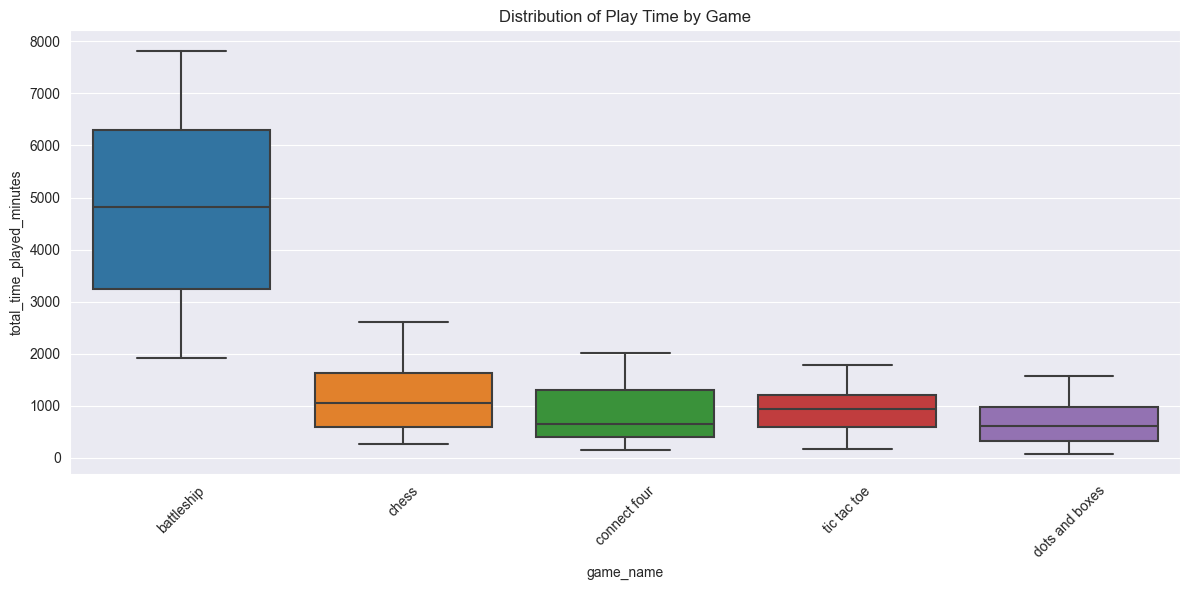

In [18]:
# Game-specific visualizations
plt.figure(figsize=(12, 6))
sns.boxplot(x='game_name', y='total_time_played_minutes', data=df)
plt.xticks(rotation=45)
plt.title('Distribution of Play Time by Game')
plt.tight_layout()
plt.show()

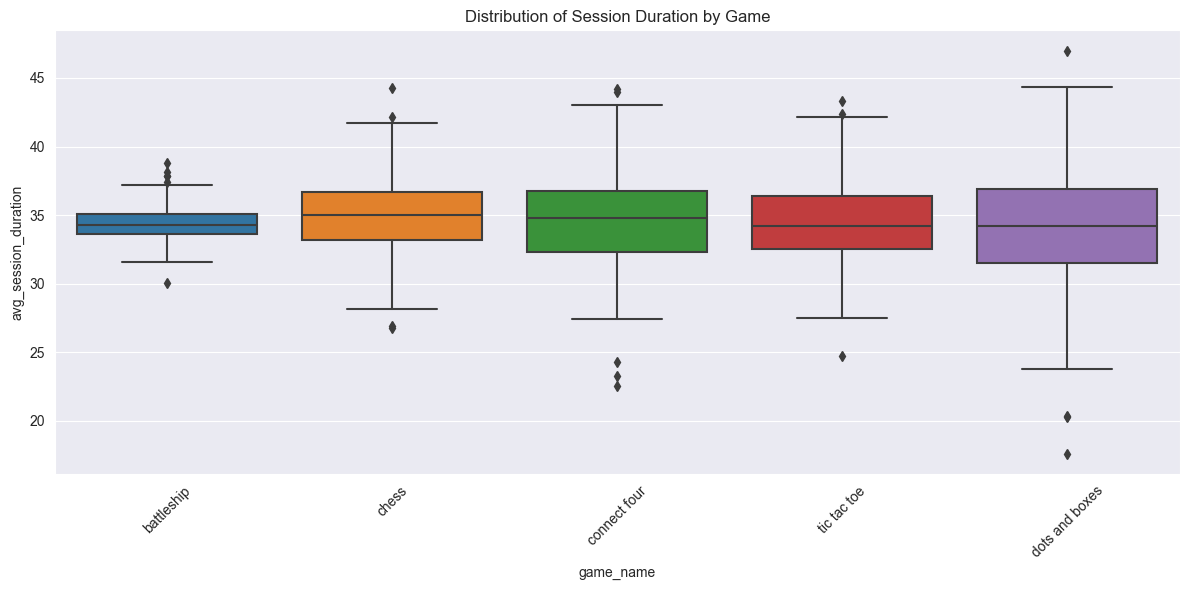

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='game_name', y='avg_session_duration', data=df)
plt.xticks(rotation=45)
plt.title('Distribution of Session Duration by Game')
plt.tight_layout()
plt.show()



Feature Importance Analysis
--------------------------------------------------


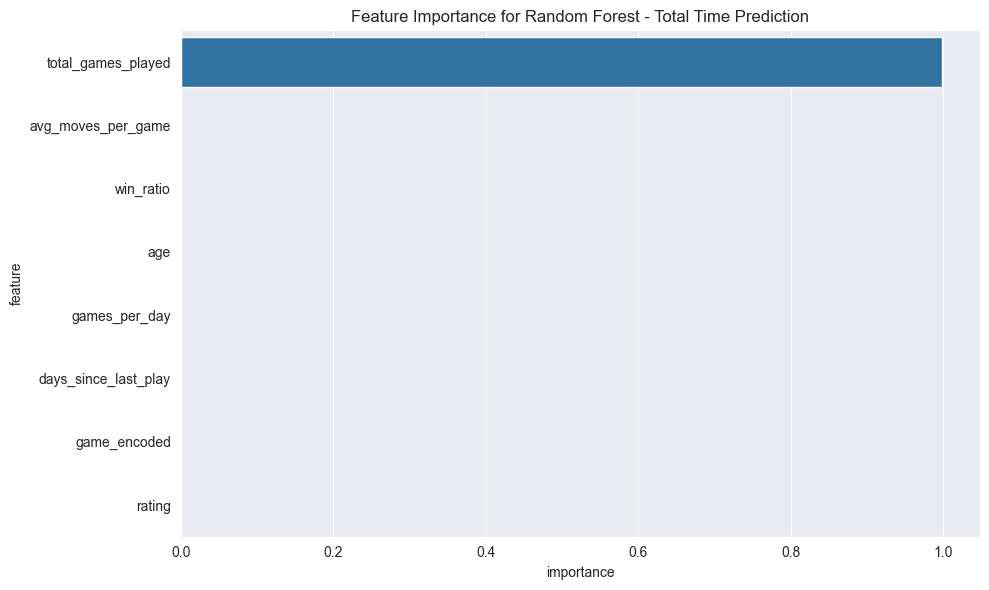

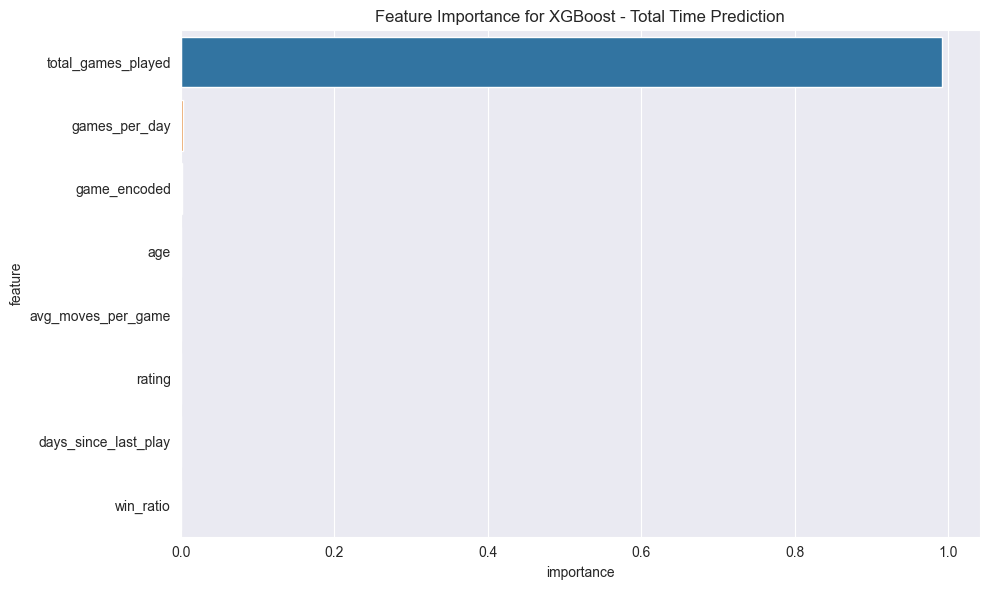

In [21]:
# Feature importance analysis
def plot_feature_importance(model, features, title):
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.best_estimator_.feature_importances_
    })
    importance = importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance)
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("\nFeature Importance Analysis")
print("-" * 50)
for name, model in models_time.items():
    if hasattr(model.best_estimator_, 'feature_importances_'):
        plot_feature_importance(
            model,
            features,
            f'Feature Importance for {name} - Total Time Prediction'
        )

In [20]:
# # Save models, scaler, and label encoder
# best_time_model = max(models_time.items(), key=lambda x: x[1].best_score_)[1]
# best_session_model = max(models_session.items(), key=lambda x: x[1].best_score_)[1]
# 
# with open('time_prediction_model.pkl', 'wb') as f:
#     pickle.dump(best_time_model, f)
#     
# with open('session_prediction_model.pkl', 'wb') as f:
#     pickle.dump(best_session_model, f)
#     
# with open('time_prediction_scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
#     
# with open('game_label_encoder.pkl', 'wb') as f:
#     pickle.dump(label_encoder, f)
#     
# 
# print("\nModel and encoder files saved successfully!")